#Predict Probability of Default Using Ratings 

In [1]:
#Load libraries
import pandas as pd
import numpy as np
import math
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, recall_score, roc_auc_score, roc_curve

In [2]:
#Import data
loans_df = pd.read_csv("Task 3 and 4_Loan_Data.csv")

In [3]:
loans_df.head()

,customer_id,credit_lines_outstanding,loan_amt_outstanding,total_debt_outstanding,income,years_employed,fico_score,default
0,8153374,0,5221.545193,3915.471226,78039.38546,5,605,0
1,7442532,5,1958.928726,8228.752520,26648.43525,2,572,1
2,2256073,0,3363.009259,2027.830850,65866.71246,4,602,0
3,4885975,0,4766.648001,2501.730397,74356.88347,5,612,0
4,4700614,1,1345.827718,1768.826187,23448.32631,6,631,0


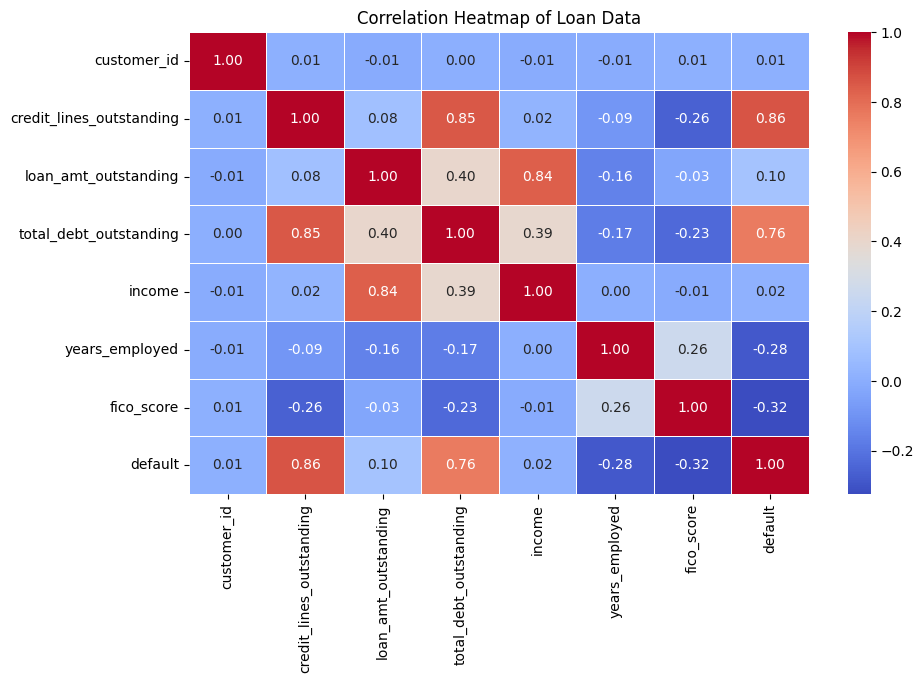

In [4]:
# Compute correlation matrix
corr_matrix = loans_df.corr()

# Create heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap="coolwarm", linewidths=0.5)

# Show the plot
plt.title("Correlation Heatmap of Loan Data")
plt.show()

In [6]:
#Associate each bucket with a rating, here it is 6 buckets
d = {range(800,851):1,range(750,800):2,range(700,750):3,
     range(650,700):4,range(600,650):5,range(300,600):6 }

#Create a column for rating
loans_df['Rating']= loans_df['fico_score'].apply(lambda x : next((r for b,r in d.items() if x in b),0))

In [7]:
loans_df

,customer_id,credit_lines_outstanding,loan_amt_outstanding,total_debt_outstanding,income,years_employed,fico_score,default,Rating
0,8153374,0,5221.545193,3915.471226,78039.38546,5,605,0,5
1,7442532,5,1958.928726,8228.752520,26648.43525,2,572,1,6
2,2256073,0,3363.009259,2027.830850,65866.71246,4,602,0,5
3,4885975,0,4766.648001,2501.730397,74356.88347,5,612,0,5
4,4700614,1,1345.827718,1768.826187,23448.32631,6,631,0,5
...,...,...,...,...,...,...,...,...,...
9995,3972488,0,3033.647103,2553.733144,42691.62787,5,697,0,4
9996,6184073,1,4146.239304,5458.163525,79969.50521,8,615,0,5
9997,6694516,2,3088.223727,4813.090925,38192.67591,5,596,0,6
9998,3942961,0,3288.901666,1043.099660,50929.37206,2,647,0,5


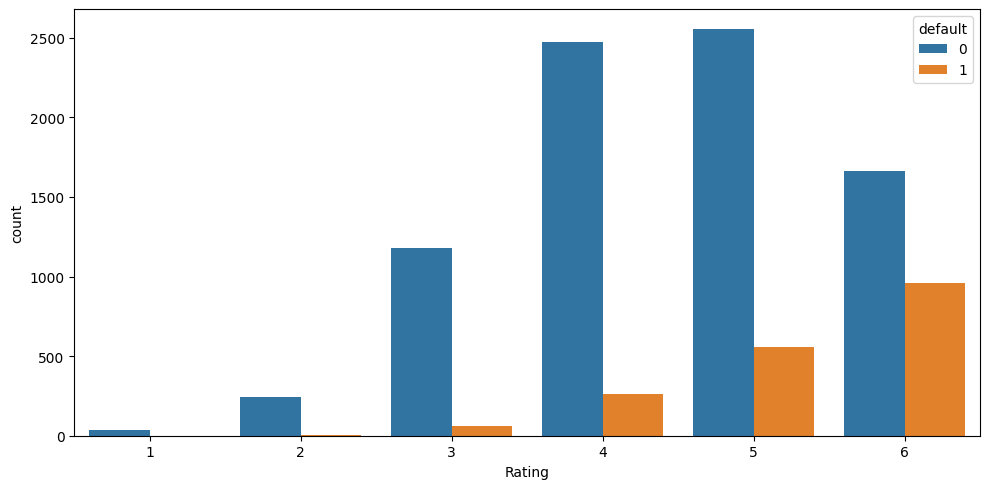

In [8]:
plt.figure(figsize=(10,5))
sns.countplot(x=loans_df['Rating'],hue=loans_df['default'])
plt.tight_layout()

##Predict the Probability of Default for the borrowers using ratings

In [9]:
loans_df[['default','Rating']]

,default,Rating
0,0,5
1,1,6
2,0,5
3,0,5
4,0,5
...,...,...
9995,0,4
9996,0,5
9997,0,6
9998,0,5


In [10]:
X = loans_df.drop(['fico_score', 'default'], axis = 1)

In [11]:
Y = loans_df['default']

In [12]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=.2, random_state=42)

In [13]:
logistic = LogisticRegression(max_iter = 10000).fit(X_train, np.ravel(Y_train))

In [14]:
#Create predictions of probability for loan status using test data
l_preds = logistic.predict_proba(X_test)

In [15]:
#Create and Print dataframes of predictions vs true values 
l_preds_df = pd.DataFrame(l_preds[:,1], columns = ['l_pred'])
true_values_df = Y_test
print(pd.concat([true_values_df.reset_index(drop=True), l_preds_df], axis = 1))

      default        l_pred
0           0  1.538504e-10
1           0  1.360253e-02
2           1  1.000000e+00
3           0  1.925444e-08
4           0  2.933487e-09
...       ...           ...
1995        0  2.344219e-11
1996        0  9.668605e-14
1997        0  3.757042e-06
1998        0  1.632552e-06
1999        0  1.585400e-02

[2000 rows x 2 columns]


In [26]:
l_preds_df.round(decimals = 0).value_counts()


l_pred  l_pred_loan_status_50
0.0     0                        1656
1.0     1                         344
Name: count, dtype: int64

In [27]:
Y_test.value_counts()

default
0    1652
1     348
Name: count, dtype: int64

In [28]:
#With a threshold of 0.5
l_preds_df['l_pred_loan_status_50'] = l_preds_df['l_pred'].apply(lambda x: 1 if x >= 0.50 else 0)

from sklearn.metrics import classification_report
target_names = ['Non-Default', 'Default']
print(classification_report(Y_test, l_preds_df['l_pred_loan_status_50'], target_names=target_names))

              precision    recall  f1-score   support

 Non-Default       0.99      1.00      0.99      1652
     Default       0.98      0.97      0.97       348

    accuracy                           0.99      2000
   macro avg       0.99      0.98      0.98      2000
weighted avg       0.99      0.99      0.99      2000



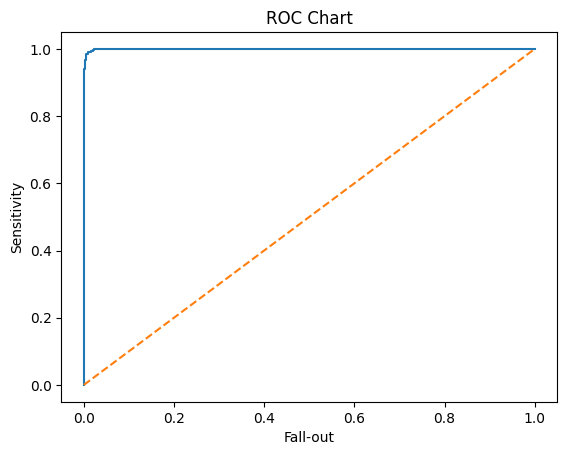

In [29]:
l_prob_default = l_preds[:, 1]
fallout, sensitivity, thresholds= roc_curve(Y_test, l_prob_default)
plt.plot(fallout, sensitivity)
plt.plot([0, 1], [0, 1], linestyle='--')
plt.title("ROC Chart")
plt.xlabel("Fall-out")
plt.ylabel("Sensitivity")
plt.show()

In [120]:
loans_df

,customer_id,credit_lines_outstanding,loan_amt_outstanding,total_debt_outstanding,income,years_employed,fico_score,default
0,8153374,0,5221.545193,3915.471226,78039.38546,5,605,0
1,7442532,5,1958.928726,8228.752520,26648.43525,2,572,1
2,2256073,0,3363.009259,2027.830850,65866.71246,4,602,0
3,4885975,0,4766.648001,2501.730397,74356.88347,5,612,0
4,4700614,1,1345.827718,1768.826187,23448.32631,6,631,0
...,...,...,...,...,...,...,...,...
9995,3972488,0,3033.647103,2553.733144,42691.62787,5,697,0
9996,6184073,1,4146.239304,5458.163525,79969.50521,8,615,0
9997,6694516,2,3088.223727,4813.090925,38192.67591,5,596,0
9998,3942961,0,3288.901666,1043.099660,50929.37206,2,647,0


##Fitting the model on the entire dataset

In [32]:
loans_df.drop(['fico_score', 'default'], inplace = True, axis = 1)

In [33]:
#LogisticRegression on the whole dataset 
proba = logistic.predict_proba(loans_df)
prob_data = pd.DataFrame(proba[:,1].round(decimals=2), columns = ['Proba_To_Default'])
loans_df = pd.concat([loans_df, prob_data], axis = 1)
loans_df

,customer_id,credit_lines_outstanding,loan_amt_outstanding,total_debt_outstanding,income,years_employed,Rating,Proba_To_Default
0,8153374,0,5221.545193,3915.471226,78039.38546,5,5,0.0
1,7442532,5,1958.928726,8228.752520,26648.43525,2,6,1.0
2,2256073,0,3363.009259,2027.830850,65866.71246,4,5,0.0
3,4885975,0,4766.648001,2501.730397,74356.88347,5,5,0.0
4,4700614,1,1345.827718,1768.826187,23448.32631,6,5,0.0
...,...,...,...,...,...,...,...,...
9995,3972488,0,3033.647103,2553.733144,42691.62787,5,4,0.0
9996,6184073,1,4146.239304,5458.163525,79969.50521,8,5,0.0
9997,6694516,2,3088.223727,4813.090925,38192.67591,5,6,0.0
9998,3942961,0,3288.901666,1043.099660,50929.37206,2,5,0.0
